In [33]:
import pandas as pd 
from langchain_core.tools import tool
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
import shutil
import uuid


In [4]:
import pandas as pd
from datetime import datetime, timedelta

# Define data
data = [
    {"id": 1, "name": "Ravi Kumar", "city": "Mumbai", "country": "India", "travelling_from": "Mumbai", "travelling_to": "Delhi", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=2)).strftime("%H:%M"), "destination_city": "Delhi", "destination_country": "India"},
    {"id": 2, "name": "Priya Singh", "city": "Chennai", "country": "India", "travelling_from": "Chennai", "travelling_to": "Bangalore", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=1)).strftime("%H:%M"), "destination_city": "Bangalore", "destination_country": "India"},
    {"id": 3, "name": "Amit Patel", "city": "Ahmedabad", "country": "India", "travelling_from": "Ahmedabad", "travelling_to": "Jaipur", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=1, minutes=45)).strftime("%H:%M"), "destination_city": "Jaipur", "destination_country": "India"},
    {"id": 4, "name": "Neha Gupta", "city": "Kolkata", "country": "India", "travelling_from": "Kolkata", "travelling_to": "Hyderabad", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=2, minutes=30)).strftime("%H:%M"), "destination_city": "Hyderabad", "destination_country": "India"},
    {"id": 5, "name": "Sanjay Verma", "city": "Bangalore", "country": "India", "travelling_from": "Bangalore", "travelling_to": "Chennai", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=1)).strftime("%H:%M"), "destination_city": "Chennai", "destination_country": "India"},
    {"id": 6, "name": "Ayesha Ali", "city": "Hyderabad", "country": "India", "travelling_from": "Hyderabad", "travelling_to": "Pune", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=1, minutes=15)).strftime("%H:%M"), "destination_city": "Pune", "destination_country": "India"},
    {"id": 7, "name": "Rajesh Singh", "city": "Delhi", "country": "India", "travelling_from": "Delhi", "travelling_to": "Kolkata", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=2)).strftime("%H:%M"), "destination_city": "Kolkata", "destination_country": "India"},
    {"id": 8, "name": "Meera Joshi", "city": "Pune", "country": "India", "travelling_from": "Pune", "travelling_to": "Mumbai", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(minutes=45)).strftime("%H:%M"), "destination_city": "Mumbai", "destination_country": "India"},
    {"id": 9, "name": "Vikram Mehta", "city": "Jaipur", "country": "India", "travelling_from": "Jaipur", "travelling_to": "Ahmedabad", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=1, minutes=30)).strftime("%H:%M"), "destination_city": "Ahmedabad", "destination_country": "India"},
    {"id": 10, "name": "Deepa Menon", "city": "Mumbai", "country": "India", "travelling_from": "Mumbai", "travelling_to": "Goa", "date_of_travel": datetime.now().strftime("%Y-%m-%d"), "destination_reach_time": (datetime.now() + timedelta(hours=1, minutes=20)).strftime("%H:%M"), "destination_city": "Goa", "destination_country": "India"}
]

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
# print(df)
df.head()


,id,name,city,country,travelling_from,travelling_to,date_of_travel,destination_reach_time,destination_city,destination_country
0,1,Ravi Kumar,Mumbai,India,Mumbai,Delhi,2024-06-09,15:17,Delhi,India
1,2,Priya Singh,Chennai,India,Chennai,Bangalore,2024-06-09,14:17,Bangalore,India
2,3,Amit Patel,Ahmedabad,India,Ahmedabad,Jaipur,2024-06-09,15:02,Jaipur,India
3,4,Neha Gupta,Kolkata,India,Kolkata,Hyderabad,2024-06-09,15:47,Hyderabad,India
4,5,Sanjay Verma,Bangalore,India,Bangalore,Chennai,2024-06-09,14:17,Chennai,India


In [16]:
@tool 
def names_of_travellers():
    """This function return the list name of all the travellers"""
    return df['name'].to_list()
# names_of_travellers()

In [17]:
@tool 
def people_from_place(cities):
    """This function returns the list of persons from a specific city"""
    filtered_df = df[df['city'].isin(cities)]
    return filtered_df['name'].to_list()

# people_from_place(["Mumbai","Hyderabad"])


In [18]:
@tool
def to_cities_they_are_travelling():
    """This function returns the list of cities all the travellers are travelling tooo"""
    return set(df['travelling_to'].to_list())
# to_cities_they_are_travelling()

In [21]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [22]:
def handle_tool_error(state)->dict:
    error = state.get('error')
    tool_calls = state['messages'][-1].tool_calls
    return {
        "messages":
        [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc['id']
            )
            for tc in tool_calls
        ]
    }

In [23]:
def create_tool_node_with_callback(tools:list)->dict:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

In [24]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [26]:
class Assistant:
    def __init__(self,runnable:Runnable):
        self.runnable= runnable
    def __call__(self,state:State,config:RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state['messages']+[('user','Respond with real output')]
                state = {**state ,"messages":messages}
            else:
                break 
        return {"messages":result}

In [27]:
llm = ChatOpenAI()

In [28]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Airlines DB. "
            " Use the provided tools to search for info like names of the travellers, people travelling to so and so places , and cities they are travelling to. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
        ),
        ("placeholder", "{messages}"),
    ]
)

In [29]:
tools  = [to_cities_they_are_travelling,people_from_place,names_of_travellers]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [31]:
builder = StateGraph(State)

builder.add_node("assistant",Assistant(assistant_runnable))
builder.add_node("tools",create_tool_node_with_callback(tools))
builder.set_entry_point("assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")
memory = SqliteSaver.from_conn_string(":memory:")

graph = builder.compile(checkpointer=memory)


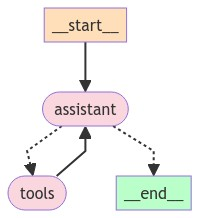

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [34]:
questions=[
    "who all are the travellers exists in our datafarme ?, please let their names",
    "List down all the names of the people who are travelling from city Mumbai and Hyderabad",
    "To which cities are the people travelling to? in our dataframe ?"
]

thread_id = str(uuid.uuid4())

config =  {
    "configurable":{"thread_id":thread_id}
}

_printed = set()

for question in questions:
    events = graph.stream({"messages": ("user", question)}, config, stream_mode="values")
    for event in events:
        _print_event(event, _printed)


================================ Human Message =================================

who all are the travellers exists in our datafarme ?, please let their names
================================== Ai Message ==================================
Tool Calls:
  names_of_travellers (call_Yp0IDk7vZVQYBWcGWbvR4YMX)
 Call ID: call_Yp0IDk7vZVQYBWcGWbvR4YMX
  Args:
================================= Tool Message =================================
Name: names_of_travellers

["Ravi Kumar", "Priya Singh", "Amit Patel", "Neha Gupta", "Sanjay Verma", "Ayesha Ali", "Rajesh Singh", "Meera Joshi", "Vikram Mehta", "Deepa Menon"]
================================== Ai Message ==================================

The travellers in our database are:
1. Ravi Kumar
2. Priya Singh
3. Amit Patel
4. Neha Gupta
5. Sanjay Verma
6. Ayesha Ali
7. Rajesh Singh
8. Meera Joshi
9. Vikram Mehta
10. Deepa Menon
================================ Human Message =================================

List down all the names of the people 